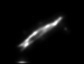

In [19]:
import requests
# import pandas as pd
# from PIL import Image
# import io
# import tensorflow as tf
# import numpy as np
repo_url_base = "https://github.com/juleshenry/quantum-mnist/blob/main/data/zooplankton_0p5x/"
plankton_names = ['aphanizomenon', 'asplanchna', 'asterionella', 'bosmina', 'brachionus', 'ceratium', 
                  'chaoborus', 'conochilus', 'copepod_skins', 'cyclops', 'daphnia', 
                  'daphnia_skins', 'diaphanosoma', 'diatom_chain', 'dinobryon', 'dirt', 'eudiaptomus',
                  'filament', 'fish', 'fragilaria', 'hydra', 'kellicottia', 'keratella_cochlearis',
                  'keratella_quadrata', 'leptodora', 'maybe_cyano', 'nauplius', 'paradileptus', 'polyarthra',
                  'rotifers', 'synchaeta', 'trichocerca', 'unknown', 'unknown_plankton', 'uroglena']
repo_data = repo_url_base + plankton + "/training_data/"
for plankton in plankton_names:
  r = requests.get(repo_url_base + plankton + "/training_data/")
  break
photo_prefix = "SPC-EAWAG-0P5X-"
file_suffix = ".jpeg"
raw_suffix = "?raw=True"
for o in str(r.content).split(photo_prefix)[1:]:
  r = requests.get(repo_data + photo_prefix + o.split(file_suffix)[0] + file_suffix + raw_suffix)
  x = Image.open(io.BytesIO(r.content))
  x  = x.convert('L')
  break
x



In [ ]:
# 1. Load the data
## -In this notebook we will:
## 1. Load the plankton data as graysale images 
## 2. Run round robin comparisons
## 3. 

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  